### Import libraries

In [1]:
import sys
import os
import gc
import pandas as pd
from functools import partial
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/machine_learning/scripts/")

In [87]:
from data_set_up import DataSetUp
from embed_car_price import tfk, EmbedCarPrice
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/data_process/scripts/")
from utils import save_object

In [4]:
EmbedCarPrice.set_gpu_limit(6)

### Split none onehot encoded data into train,dev and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/processed_data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price 

In [6]:
data_setup = DataSetUp(features,y)
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,True,2020,0.11)

### We will embed columns model, transmission, fuelType, and brand

--- 

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants for base model

In [8]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [9]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

* model embed model input 
* transmission embed model input
* brand embed model input 
* fuelType embed model input 
* numeric input data 

### Perform categorical feature transformation

In [10]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [11]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [12]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [13]:
base_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr)

In [19]:
carPrice_embed = EmbedCarPrice(base_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [27]:
carPrice_embed.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

,r2_score,rmse,price_diff_abs_max
train,0.941727,2381.125394,672.539198


In [21]:
carPrice_embed.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.935878,2442.623189,610.638747


In [22]:
carPrice_embed.save_model("cate_embed_base_model.h5")

In [23]:
base_embed_model = EmbedCarPrice.load_model("cate_embed_base_model.h5")

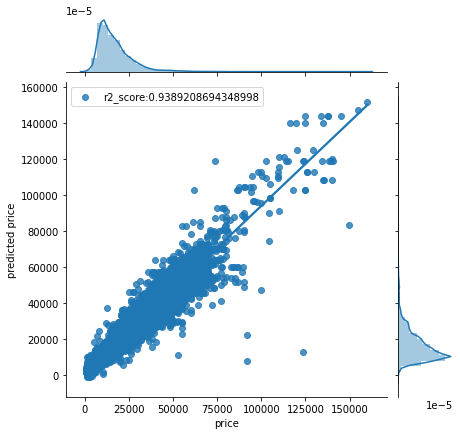

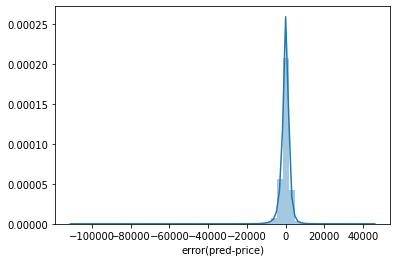

In [24]:
carPrice_embed.plot_pred_price(features_list,y)

In [25]:
price_table = carPrice_embed.price_diff(features,y,features_list)

In [26]:
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,1,0,3,0,672.539198,672.539198
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,655.124726,655.124726
39978,A Class,Manual,Petrol,merc,1,5,1,0,610.638747,610.638747
39711,C Class,Automatic,Diesel,merc,1,2,1,1,596.627234,596.627234
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,532.798739,532.798739
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,491.481766,491.481766
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,443.949255,443.949255
39540,M Class,Semi-Auto,Petrol,merc,1,5,1,1,412.202087,412.202087
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,391.706258,391.706258
72016,Focus,Manual,Petrol,ford,1,5,2,0,341.720476,341.720476


### similar to regular NN

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [14]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [15]:
bigger_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,
                                                     X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [17]:
carPrice_embed_bigger = EmbedCarPrice(bigger_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [18]:
carPrice_embed_bigger.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.943776,2338.885517,701.052192


In [19]:
carPrice_embed_bigger.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.937064,2419.922708,341.538048


In [20]:
carPrice_embed_bigger.save_model("bigger_embed.h5")

In [21]:
bigger_embed = EmbedCarPrice.load_model("bigger_embed.h5")

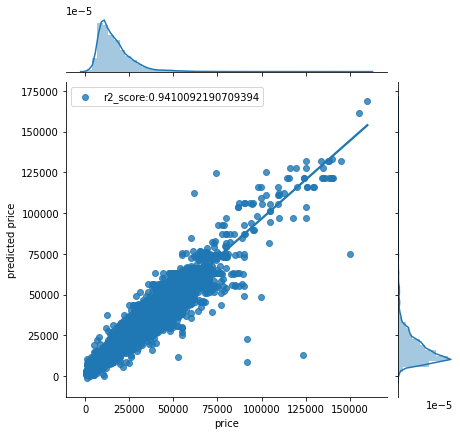

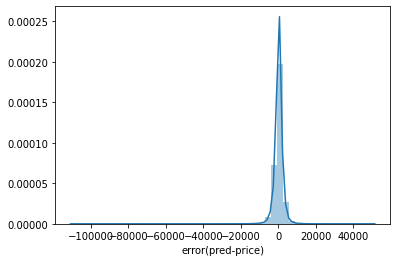

In [22]:
carPrice_embed_bigger.plot_pred_price(features_list,y)

In [23]:
price_table = carPrice_embed_bigger.price_diff(features,y,features_list)

In [24]:
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,1,0,3,0,701.052192,701.052192
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,678.596716,678.596716
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,544.818054,544.818054
39711,C Class,Automatic,Diesel,merc,1,2,1,1,539.077197,539.077197
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,469.191691,469.191691
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,400.513386,400.513386
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,396.827763,396.827763
39540,M Class,Semi-Auto,Petrol,merc,1,5,1,1,388.236656,388.236656
39978,A Class,Manual,Petrol,merc,1,5,1,0,341.538048,341.538048
71617,Fiesta,Manual,Petrol,ford,1,4,2,0,327.830413,327.830413


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [25]:
EMBED_COLS = ["model","transmission","brand","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in features.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [26]:
data_setup.categorical_mapping(X_train,EMBED_COLS)

In [27]:
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [28]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [29]:
all_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr,2)

In [30]:
carPrice_embed_all = EmbedCarPrice(all_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [37]:
carPrice_embed_all.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

,r2_score,rmse,price_diff_abs_max
train,0.946604,2279.312564,460.742459


In [32]:
carPrice_embed_all.regression_metrics(X_test_list,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.939804,2366.658146,231.284968


In [33]:
carPrice_embed_all.save_model("All_embed.h5")

In [34]:
all_embed = EmbedCarPrice.load_model("All_embed.h5")

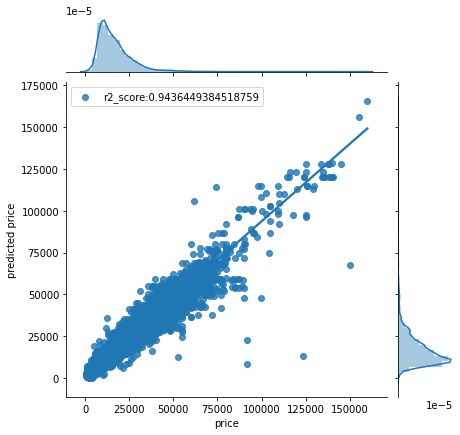

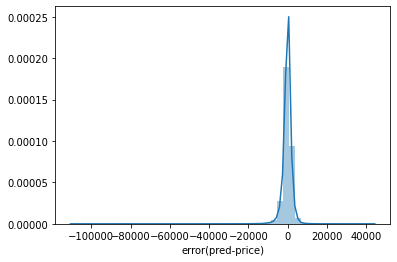

In [35]:
carPrice_embed_all.plot_pred_price(features_list,y)

In [36]:
price_table = carPrice_embed_all.price_diff(features,y,features_list)
price_table.head(20)

,model,transmission,fuelType,brand,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
20061,Beetle,Automatic,Petrol,vw,1,0,1,0,460.742459,460.742459
44539,Corsa,Manual,Petrol,vauxhall,1,4,3,0,457.882388,457.882388
11984,Golf,Manual,Diesel,vw,1,0,3,0,437.112044,437.112044
77582,Santa Fe,Manual,Petrol,hyundi,1,4,1,1,387.896647,387.896647
39711,C Class,Automatic,Diesel,merc,1,2,1,1,334.351909,334.351909
47201,Astra,Manual,Petrol,vauxhall,1,5,2,0,324.522135,324.522135
71819,Mondeo,Manual,Diesel,ford,1,0,2,0,321.693445,321.693445
69135,Mondeo,Manual,Diesel,ford,1,4,2,0,315.575376,315.575376
39540,M Class,Semi-Auto,Petrol,merc,1,5,1,1,298.956816,298.956816
71617,Fiesta,Manual,Petrol,ford,1,4,2,0,298.324998,298.324998


### Slightly improved, still have same issues with older year. Let's import original raw data

In [39]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/processed_data/car_data_raw.csv")
features_raw,y_raw = data_raw.drop("price",axis=1),data_raw.price

In [40]:
data_setup_raw = DataSetUp(features_raw,y_raw)
X_train_raw,X_dev_raw,X_test_raw,y_train_raw,y_dev_raw,y_test_raw = data_setup_raw.data_split(2020,0.1,True,2020,0.11)

In [41]:
EMBED_COLS = ["model","transmission","brand","fuelType","year"]
NONEMBED_COLS = [c for c in X_train_raw.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [42]:
data_setup_raw.categorical_mapping(X_train_raw,EMBED_COLS)

In [43]:
X_train_list_r,X_dev_list_r = data_setup_raw.cate_data_list(X_train_raw),data_setup_raw.cate_data_list(X_dev_raw)
X_test_list_r, features_list_r = data_setup_raw.cate_data_list(X_test_raw),data_setup_raw.cate_data_list(features_raw)

In [44]:
train_dataset_r,dev_dataset_r = (X_train_list_r,y_train_raw),(X_dev_list_r,y_dev_raw)

In [45]:
carPrice_embed_raw = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_raw,
                                                     numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [46]:
carPrice_embed_raw = EmbedCarPrice(carPrice_embed_raw,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [47]:
carPrice_embed_raw.regression_metrics(X_train_list_r,y_train_raw,"train",True,train_dataset_r,dev_dataset_r,0)

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.939784,2420.493017,971.147352


In [48]:
carPrice_embed_raw.regression_metrics(X_test_list_r,y_test_raw,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.935868,2442.804105,368.683744


In [49]:
carPrice_embed_raw.save_model("model_embed_raw.h5")

In [50]:
embed_model_r = EmbedCarPrice.load_model("model_embed_raw.h5")

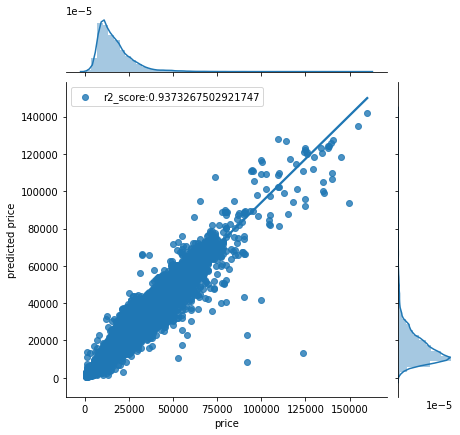

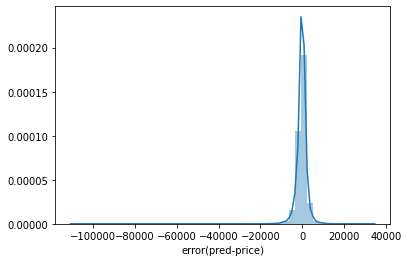

In [51]:
carPrice_embed_raw.plot_pred_price(features_list_r,y_raw)

In [52]:
price_table = carPrice_embed_raw.price_diff(features_raw,y_raw,features_list_r)
price_table.head(20)

,model,year,transmission,mileage,fuelType,mpg,engineSize,brand,price_diff_pct,price_diff_abs
11984,Golf,2008,Manual,1,Diesel,53.3,1.9,vw,971.147352,971.147352
71819,Mondeo,2008,Manual,1,Diesel,47.9,2.0,ford,772.674969,772.674969
20061,Beetle,2001,Automatic,1,Petrol,29.7,2.0,vw,709.528165,709.528165
72016,Focus,2003,Manual,177644,Petrol,41.5,1.6,ford,430.203204,430.203204
39978,A Class,2003,Manual,109090,Petrol,40.0,1.4,merc,368.683744,368.683744
83274,Z4,2014,Manual,31074,Petrol,41.5,2.0,bmw,332.227991,332.227991
27964,Octavia,2010,Manual,300000,Diesel,57.6,1.9,skoda,329.999056,329.999056
52100,Zafira,2013,Manual,279000,Diesel,55.4,1.7,vauxhall,309.311471,309.311471
39336,S Class,2001,Automatic,108800,Diesel,31.7,3.2,merc,264.743098,264.743098
40170,A Class,2010,Manual,116126,Diesel,54.3,2.0,merc,258.127315,258.127315


### Let's use binned numeric data instead of raw numeric value

In [53]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)
features_c,y_c = combined.drop("price",axis=1), combined.price

In [54]:
data_setup_c = DataSetUp(features_c,y_c)

In [55]:
X_train_c,X_dev_c,X_test_c,y_train_c,y_dev_c,y_test_c  = data_setup_c.data_split(2020,0.05,True,2020,0.05)

In [56]:
EMBED_COLS = ["model","transmission","brand","fuelType","year","mil_cat","binned_mpg","engine_binned"]
NONEMBED_COLS = [c for c in X_train_c.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [57]:
data_setup_c.categorical_mapping(X_train_c,EMBED_COLS)

In [58]:
X_train_list_c,X_dev_list_c = data_setup_c.cate_data_list(X_train_c), data_setup_c.cate_data_list(X_dev_c)

In [59]:
X_test_list_c,features_list_c = data_setup_c.cate_data_list(X_test_c),data_setup_c.cate_data_list(features_c)

In [60]:
X_train_dataset_c,X_dev_dataset_c = (X_train_list_c,y_train_c),(X_dev_list_c,y_dev_c)

In [61]:
embed_model_c= EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_c,
                                               numeric_size,model_size,DROPOUT,
                                               METRICS,lr,2)

In [62]:
carPriceEmbed_c = EmbedCarPrice(embed_model_c,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [64]:
carPriceEmbed_c.regression_metrics(X_train_list_c,y_train_c,"train",True,X_train_dataset_c,X_dev_dataset_c,0)

Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.951795,2172.023907,376.69549


In [65]:
carPriceEmbed_c.regression_metrics(X_test_list_c,y_test_c,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.954087,2029.12447,143.812907


In [66]:
carPriceEmbed_c.save_model("combined_embed_all.h5")

In [67]:
embed_model_c= EmbedCarPrice.load_model("combined_embed_all.h5")

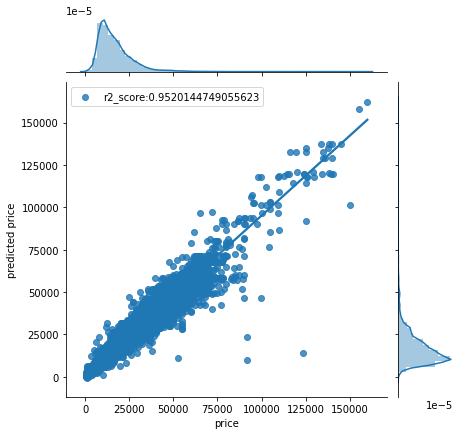

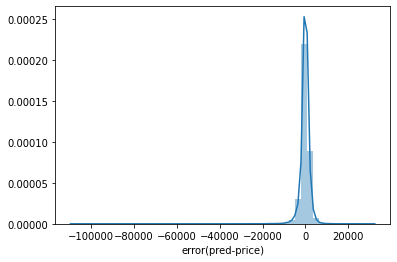

In [68]:
carPriceEmbed_c.plot_pred_price(features_list_c,y_c)

In [69]:
price_table = carPriceEmbed_c.price_diff(features_c,y_c,features_list_c)
price_table.head(20)

,model,transmission,fuelType,brand,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,0,3,0,2008,376.695490,376.695490
71819,Mondeo,Manual,Diesel,ford,0,2,0,2008,346.959463,346.959463
83274,Z4,Manual,Petrol,bmw,3,2,0,2014,305.189369,305.189369
20061,Beetle,Automatic,Petrol,vw,0,1,0,2001,299.805910,299.805910
71617,Fiesta,Manual,Petrol,ford,4,2,0,2008,275.309784,275.309784
87561,Z3,Manual,Petrol,bmw,3,1,1,2001,243.725775,243.725775
77582,Santa Fe,Manual,Petrol,hyundi,4,1,1,2002,240.548869,240.548869
39711,C Class,Automatic,Diesel,merc,2,1,1,2002,239.600295,239.600295
87481,3 Series,Automatic,Petrol,bmw,4,1,1,1999,228.213888,228.213888
39540,M Class,Semi-Auto,Petrol,merc,5,1,1,2004,223.547345,223.547345


### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

2798/2798 [==============================] - 10s 4ms/step - loss: 380705536.0000 - MAPE: 100.0000 - MAE: 16817.8184 - val_loss: 374850272.0000 - val_MAPE: 99.9948 - val_MAE: 16710.2930


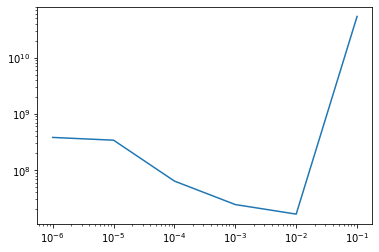

In [70]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
mdl_setup = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=2.0)
EmbedCarPrice.param_search(learning_rates,mdl_setup,X_train_dataset_c,X_dev_dataset_c,1)

### learning rate of 0.001 seems to work the best

### tune embed multiplier

In [71]:
mdl_partial = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,NONEMBED_COLS,
                    X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2798/2798 [==============================] - 10s 4ms/step - loss: 22535974.0000 - MAPE: 18.5255 - MAE: 2719.7830 - val_loss: 12763326.0000 - val_MAPE: 13.4337 - val_MAE: 2004.1322


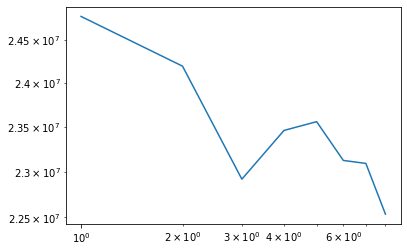

In [72]:
multiplier = [1,2,3,4,5,6,7,8]
EmbedCarPrice.param_search(multiplier,mdl_partial,X_train_dataset_c,X_dev_dataset_c,1)

### multipler of 3 seems to work the best

### increase training size and train on feature set

In [78]:
data_setup_final = DataSetUp(features_c,y_c)

In [79]:
X_train_final,X_test_final,y_train_final,y_test_final = data_setup_final.data_split(2020,0.1)

In [80]:
final_mdl = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,X_train_final,
                                               numeric_size,model_size,DROPOUT,
                                               METRICS,lr,3)

In [81]:
carPriceEmbed_c_final = EmbedCarPrice(final_mdl,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [82]:
data_setup_final.categorical_mapping(X_train_final,EMBED_COLS)

### Save final categorical mapping for car price model application

In [88]:
cate_map_final = data_setup_final.val_maps

In [90]:
save_object(f"{home}/Documents/projects/Car-Price-Model-Application/saved_dict_mappings/cate_map.pkl",
           cate_map_final)

In [91]:
X_train_final_list = data_setup_final.cate_data_list(X_train_final)
X_test_final_list = data_setup_final.cate_data_list(X_test_final)

In [92]:
train_data_final,test_data_final = (X_train_final_list,y_train_final),(X_test_final_list,y_test_final)

In [93]:
features_list_final = data_setup_final.cate_data_list(features_c)

In [95]:
carPriceEmbed_c_final.regression_metrics(X_train_final_list,y_train_final,
                                        "train",True, train_data_final,test_data_final,0)

Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.951199,2184.978714,444.345222


In [96]:
carPriceEmbed_c_final.regression_metrics(X_test_final_list,y_test_final,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.94909,2176.476024,193.444204


### Save this model as one of car price model ensemble

In [98]:
carPriceEmbed_c_final.save_model(f"{home}/Documents/projects/Car-Price-Model-Application/"
                                 "saved_models/final_embed_mdl.h5")

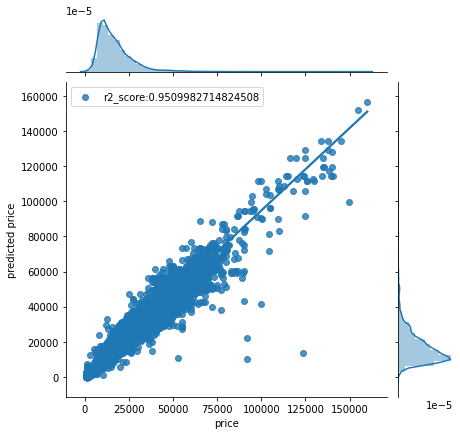

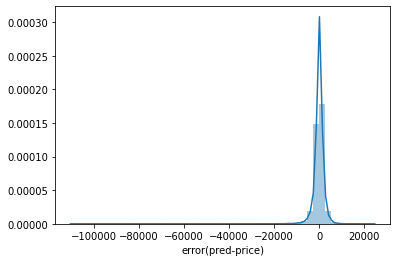

In [99]:
carPriceEmbed_c_final.plot_pred_price(features_list_final,y_c)

In [100]:
price_table = carPriceEmbed_c_final.price_diff(features_c,y_c,features_list_final)
price_table.head(20)

,model,transmission,fuelType,brand,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,vw,0,3,0,2008,444.345222,444.345222
71819,Mondeo,Manual,Diesel,ford,0,2,0,2008,357.105563,357.105563
83274,Z4,Manual,Petrol,bmw,3,2,0,2014,307.669000,307.669000
71617,Fiesta,Manual,Petrol,ford,4,2,0,2008,269.537653,269.537653
69135,Mondeo,Manual,Diesel,ford,4,2,0,2005,223.601165,223.601165
39540,M Class,Semi-Auto,Petrol,merc,5,1,1,2004,214.140160,214.140160
52100,Zafira,Manual,Diesel,vauxhall,5,3,0,2013,206.754102,206.754102
78800,X3,Semi-Auto,Diesel,bmw,2,3,0,2013,204.903840,204.903840
29517,GLE Class,Semi-Auto,Diesel,merc,4,2,1,2016,204.190146,204.190146
39978,A Class,Manual,Petrol,merc,5,1,0,2003,193.444204,193.444204


### Conclusions

### Will use final mdl and RF mdl as an esemble approach